In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression # Alternative model
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score

# Load the dataset
# The dataset often has encoding issues and unnecessary columns, let's handle that.
try:
    df = pd.read_csv('spam.csv', encoding='latin1')
except FileNotFoundError:
    print("Error: spam.csv not found. Please download it and place it in the project directory.")
    exit()

# Drop unnecessary columns and rename the main ones
df = df.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], errors='ignore') # 'errors=ignore' in case they don't exist
df.rename(columns={'v1': 'label', 'v2': 'message'}, inplace=True)

print("--- Dataset Head ---")
print(df.head())
print(f"\nShape: {df.shape}")
df.info()

print("\n--- Missing Values ---")
print(df.isnull().sum())

print("\n--- Label Distribution ---")
print(df['label'].value_counts())

# Convert labels to numerical (0 for ham, 1 for spam)
df['label_num'] = df['label'].map({'ham': 0, 'spam': 1})
print(df.head())

--- Dataset Head ---
  label                                            message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...

Shape: (5572, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB

--- Missing Values ---
label      0
message    0
dtype: int64

--- Label Distribution ---
label
ham     4825
spam     747
Name: count, dtype: int64
  label                                            message  label_num
0   ham  Go until jurong point, crazy.. Available only ...          0
1   ham                

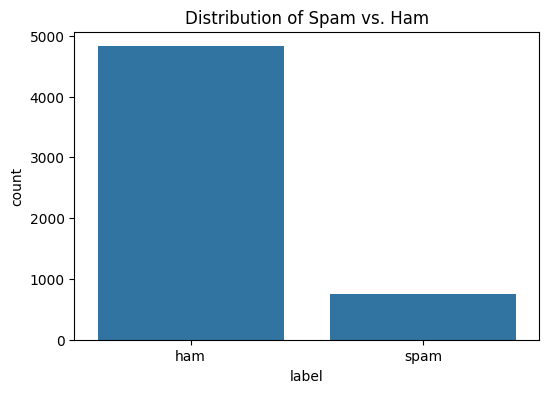

  label                                            message  label_num  \
0   ham  Go until jurong point, crazy.. Available only ...          0   
1   ham                      Ok lar... Joking wif u oni...          0   
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...          1   
3   ham  U dun say so early hor... U c already then say...          0   
4   ham  Nah I don't think he goes to usf, he lives aro...          0   

   message_length  
0             111  
1              29  
2             155  
3              49  
4              61  


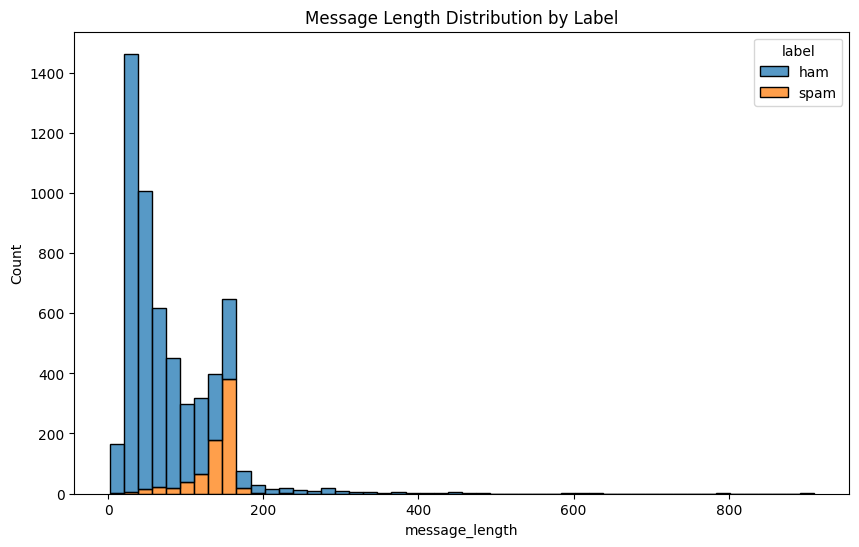

In [2]:
# Visualize label distribution
plt.figure(figsize=(6,4))
sns.countplot(x='label', data=df)
plt.title('Distribution of Spam vs. Ham')
plt.show() # or plt.savefig('label_distribution.png')

# Add message length as a feature (often useful for spam detection)
df['message_length'] = df['message'].apply(len)
print(df.head())

# Compare message length for spam vs. ham
plt.figure(figsize=(10,6))
sns.histplot(data=df, x='message_length', hue='label', multiple='stack', bins=50)
plt.title('Message Length Distribution by Label')
plt.show() # or plt.savefig('message_length_distribution.png')

In [3]:
# Convert messages to lowercase
df['processed_message'] = df['message'].str.lower()

# (Optional: More advanced preprocessing using NLTK - can be added later)
# import nltk
# from nltk.corpus import stopwords
# from nltk.stem import PorterStemmer
# nltk.download('stopwords', quiet=True)
# nltk.download('punkt', quiet=True)
#
# stop_words = set(stopwords.words('english'))
# stemmer = PorterStemmer()
#
# def preprocess_text_advanced(text):
#     words = nltk.word_tokenize(text)
#     words = [word for word in words if word.isalpha()] # Remove punctuation and numbers
#     words = [word for word in words if word not in stop_words]
#     words = [stemmer.stem(word) for word in words]
#     return " ".join(words)
#
# df['processed_message_advanced'] = df['processed_message'].apply(preprocess_text_advanced)
# print(df[['message', 'processed_message', 'processed_message_advanced']].head())
# For now, we will use the simple lowercase version:
# X_text = df['processed_message']

X_text = df['processed_message'] # Our text features
y = df['label_num']       # Our numerical labels

In [4]:
X_train_text, X_test_text, y_train, y_test = train_test_split(X_text, y, test_size=0.25, random_state=42, stratify=y)

print(f"Training set size: {len(X_train_text)}")
print(f"Test set size: {len(X_test_text)}")

Training set size: 4179
Test set size: 1393


In [5]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.9, min_df=2) # Experiment with parameters

# Fit the vectorizer on the training data and transform training data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_text)

# Transform the test data using the already fitted vectorizer
X_test_tfidf = tfidf_vectorizer.transform(X_test_text)

print(f"\nShape of TF-IDF matrix for training data: {X_train_tfidf.shape}")
print(f"Shape of TF-IDF matrix for test data: {X_test_tfidf.shape}")
# The second dimension is the size of your vocabulary (number of unique words/features)


Shape of TF-IDF matrix for training data: (4179, 3267)
Shape of TF-IDF matrix for test data: (1393, 3267)


In [6]:
# --- Multinomial Naive Bayes ---
nb_classifier = MultinomialNB(alpha=1.0) # alpha is the smoothing parameter
nb_classifier.fit(X_train_tfidf, y_train)

# Make predictions on the test set
y_pred_nb = nb_classifier.predict(X_test_tfidf)

# --- (Optional) Logistic Regression ---
# lr_classifier = LogisticRegression(solver='liblinear', random_state=42)
# lr_classifier.fit(X_train_tfidf, y_train)
# y_pred_lr = lr_classifier.predict(X_test_tfidf)

In [7]:
def evaluate_model(y_true, y_pred, model_name="Model"):
    print(f"\n--- {model_name} Performance ---")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision (Spam): {precision_score(y_true, y_pred, pos_label=1):.4f}") # Assuming 1 is spam
    print(f"Recall (Spam): {recall_score(y_true, y_pred, pos_label=1):.4f}")
    print(f"F1-Score (Spam): {f1_score(y_true, y_pred, pos_label=1):.4f}")
    print("\nConfusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=['ham', 'spam']))

# Evaluate Naive Bayes
evaluate_model(y_test, y_pred_nb, "Multinomial Naive Bayes")

# Evaluate Logistic Regression (if trained)
# evaluate_model(y_test, y_pred_lr, "Logistic Regression")


--- Multinomial Naive Bayes Performance ---
Accuracy: 0.9742
Precision (Spam): 0.9935
Recall (Spam): 0.8128
F1-Score (Spam): 0.8941

Confusion Matrix:
 [[1205    1]
 [  35  152]]

Classification Report:
               precision    recall  f1-score   support

         ham       0.97      1.00      0.99      1206
        spam       0.99      0.81      0.89       187

    accuracy                           0.97      1393
   macro avg       0.98      0.91      0.94      1393
weighted avg       0.97      0.97      0.97      1393



In [8]:
def predict_new_message(message, vectorizer, model):
    processed_message = message.lower() # Same preprocessing as training
    # If using advanced preprocessing, apply it here:
    # processed_message = preprocess_text_advanced(processed_message)
    message_tfidf = vectorizer.transform([processed_message])
    prediction = model.predict(message_tfidf)
    probability = model.predict_proba(message_tfidf)
    return "spam" if prediction[0] == 1 else "ham", probability[0]

# Example new messages
new_message_1 = "Congratulations! You've won a $1000 Walmart gift card. Go to http://example.com to claim now."
new_message_2 = "Hey, are you free for a meeting tomorrow at 2 PM?"

pred_1, prob_1 = predict_new_message(new_message_1, tfidf_vectorizer, nb_classifier)
print(f"\nMessage: '{new_message_1}' -> Prediction: {pred_1}, Probabilities (ham, spam): {prob_1}")

pred_2, prob_2 = predict_new_message(new_message_2, tfidf_vectorizer, nb_classifier)
print(f"Message: '{new_message_2}' -> Prediction: {pred_2}, Probabilities (ham, spam): {prob_2}")


Message: 'Congratulations! You've won a $1000 Walmart gift card. Go to http://example.com to claim now.' -> Prediction: spam, Probabilities (ham, spam): [0.08724772 0.91275228]
Message: 'Hey, are you free for a meeting tomorrow at 2 PM?' -> Prediction: ham, Probabilities (ham, spam): [0.97735713 0.02264287]
